In [36]:
from datetime import datetime
import pandas as pd 
import numpy as np
import seaborn as sns
import os
import random
import matplotlib 
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

def load_data():
    netflix_csv_file = open("netflix_rating.csv", mode = "w")
    rating_files = ['combined_data.txt']
    for file in rating_files:
        with open(file) as f:
            for line in f:
                line = line.strip()
                if line.endswith(":"):
                    movie_id = line.replace(":", "")
                else:
                    row_data = []
                    row_data = [item for item in line.split(",")]
                    row_data.insert(0, movie_id)
                    netflix_csv_file.write(",".join(row_data))
                    netflix_csv_file.write('\n')

    netflix_csv_file.close()
    df = pd.read_csv('netflix_rating.csv', sep=",", names = ["movie_id","customer_id", "rating", "date"])
    return df

netflix_rating_df = load_data()
netflix_rating_df
netflix_rating_df.head()


,movie_id,customer_id,rating,date
0,13368,2385003,4.0,2004-07-08
1,13368,659432,3.0,2005-03-16
2,13368,751812,2.0,2002-12-16
3,13368,2625420,2.0,2004-05-25
4,13368,1650301,1.0,2005-08-30


In [37]:
#Find duplicate ratings
netflix_rating_df.duplicated(["movie_id","customer_id", "rating", "date"]).sum()

0

In [39]:
# split train and test data
split_value = int(len(netflix_rating_df) * 0.80)
train_data = netflix_rating_df[:split_value]
test_data = netflix_rating_df[split_value:]

C:\Users\medio\AppData\Local\Temp\ipykernel_19320\173074789.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([num for num in ax.get_yticks()])


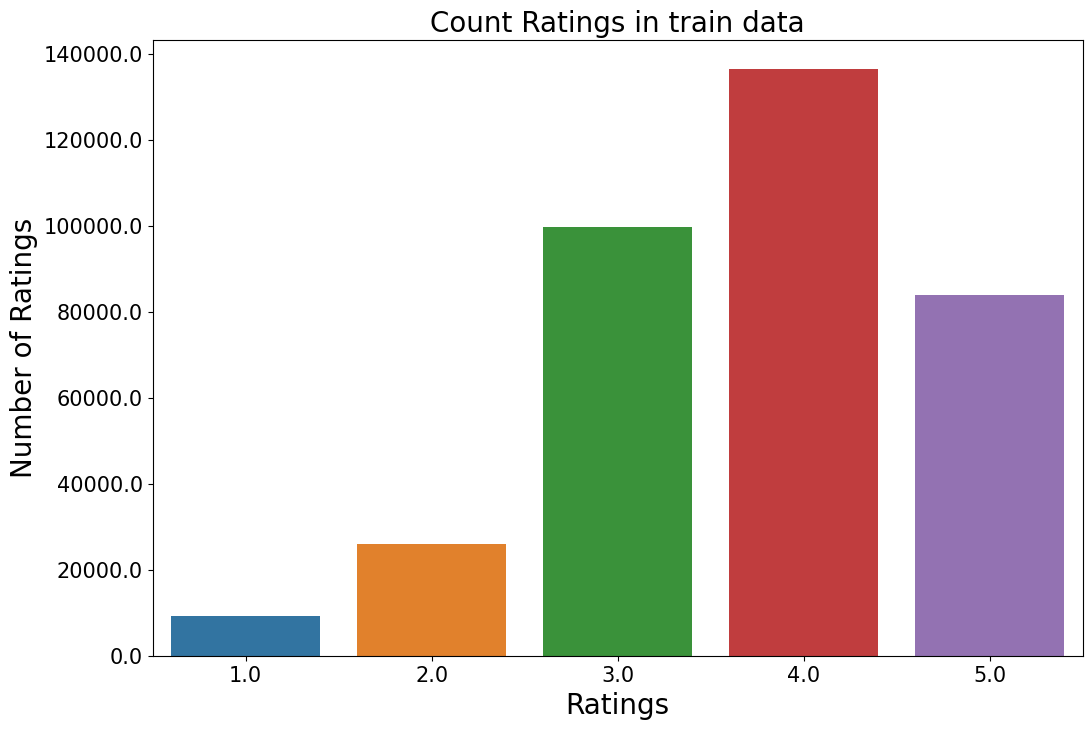

In [40]:
# count number of ratings in training dataset
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=train_data)

ax.set_yticklabels([num for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Count Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

In [23]:
# number of rated movies per user
no_rated_movies_per_movie = train_data.groupby(by="movie_id")["rating"].count().sort_values(ascending=False)
no_rated_movies_per_movie.head()

movie_id
13402    83564
13391    78944
13392    50850
13384    37884
13389    16613
Name: rating, dtype: int64

In [41]:
# create user-item sparse matrix
def get_user_item_sparse_matrix(df):
    sparse_data = sparse.csr_matrix((df.rating, (df.customer_id, df.movie_id)))
    return sparse_data

In [25]:
# user item train sparse matrix
train_sparse_data = get_user_item_sparse_matrix(train_data)

In [26]:
# user item test sparse matrix
test_sparse_data = get_user_item_sparse_matrix(test_data)

In [42]:
# global average rating
global_average_rating = train_sparse_data.sum()/train_sparse_data.count_nonzero()
print("Global Average Rating: {}".format(global_average_rating))

Global Average Rating: 3.7310275276910767


In [43]:
# check cold start problem
def get_average_rating(sparse_matrix, is_user):
    ax = 1 if is_user else 0
    sum_of_ratings = sparse_matrix.sum(axis = ax).A1
    no_of_ratings = (sparse_matrix != 0).sum(axis = ax).A1
    rows, cols = sparse_matrix.shape
    average_ratings = {i: sum_of_ratings[i]/no_of_ratings[i] for i in range(rows if is_user else cols) if no_of_ratings[i] != 0}
    return average_ratings

In [44]:
# average rating user
average_rating_user = get_average_rating(train_sparse_data, True)

In [46]:
# average rating user
avg_rating_movie = get_average_rating(train_sparse_data, False)

In [48]:
# check cold start problem for user 
total_users = len(np.unique(netflix_rating_df["customer_id"]))
train_users = len(average_rating_user)
uncommonUsers = total_users - train_users

print("Total no. of Users = {}".format(total_users))
print("No. of Users in train data= {}".format(train_users))
print("No. of Users not present in train data = {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total no. of Users = 193123
No. of Users in train data= 174612
No. of Users not present in train data = 18511(10.0%)


In [51]:
# check cold start problem for movie
total_movies = len(np.unique(netflix_rating_df["movie_id"]))
train_movies = len(avg_rating_movie)
uncommonMovies = total_movies - train_movies

print("Total no. of Movies = {}".format(total_movies))
print("No. of Movies in train data= {}".format(train_movies))
print("No. of Movies not present in train data = {}({}%)".format(uncommonMovies, np.round((uncommonMovies/total_movies)*100), 2))

Total no. of Movies = 53
No. of Movies in train data= 45
No. of Movies not present in train data = 8(15.0%)


In [52]:
def compute_user_similarity(sparse_matrix, limit=100):
    row_index, col_index = sparse_matrix.nonzero()
    rows = np.unique(row_index)
    similar_arr = np.zeros(61700).reshape(617,100)

    for row in rows[:limit]:
        sim = cosine_similarity(sparse_matrix.getrow(row), train_sparse_data).ravel()
        similar_indices = sim.argsort()[-limit:]
        similar = sim[similar_indices]
        similar_arr[row] = similar

    return similar_arr

similar_user_matrix = compute_user_similarity(train_sparse_data, 100)

IndexError: index 623 is out of bounds for axis 0 with size 617

In [53]:
similar_user_matrix[0]

NameError: name 'similar_user_matrix' is not defined

In [56]:
movie_titles_df = pd.read_csv("movie_titles.csv",sep = ",",
                              header = None, names=['movie_id', 'year_of_release', 'movie_title'],
                              index_col = "movie_id", encoding = "iso8859_2")
movie_titles_df.head()


ParserError: Error tokenizing data. C error: Expected 3 fields in line 72, saw 4
